# 📘 1강 (PyTorch, CPU): CIFAR-10 분류 — **데이터 탐색 → MLP vs CNN → 내부 시각화 → 오분류 분석 → 개선 → 챌린지**

> **촬영용 스크립트 가이드 포함**: 각 섹션 상단에 말하기 포인트와 질문 프롬프트를 넣었습니다.


## 0. 환경 설정 및 라이브러리

In [1]:
import os, time, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report
import itertools

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

# 역정규화 유틸
inv_mean = np.array([0.4914,0.4822,0.4465])
inv_std  = np.array([0.2470,0.2435,0.2616])
def denorm(img_tensor):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = img * inv_std + inv_mean
    return np.clip(img, 0, 1)

Device: cpu


## 1. 데이터 탐색 심화 (≈6분)

**말하기 포인트:**  
- 사람은 선/색/질감으로 사물을 구분합니다. 모델도 비슷한 단서(특징)를 학습합니다.
- CIFAR-10의 크기/채널/범위를 확인하고, 입력 전처리의 필요성을 짚습니다.

**질문:** “여러분은 자동차와 개를 사진에서 어떻게 구분하시나요?”


In [2]:
# 전처리: 정규화
train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616))
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616))
])

root='./data'
train_full = datasets.CIFAR10(root=root, train=True, download=True, transform=train_tf)
test_set   = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tf)
class_names = train_full.classes

# Split
val_ratio=0.2
val_len  = int(len(train_full)*val_ratio)
train_len= len(train_full)-val_len
train_set, val_set = random_split(train_full,[train_len,val_len])

train_loader=DataLoader(train_set,batch_size=128,shuffle=True,num_workers=0)
val_loader  =DataLoader(val_set,  batch_size=128,shuffle=False,num_workers=0)
test_loader =DataLoader(test_set,  batch_size=128,shuffle=False,num_workers=0)

print('Train/Val/Test sizes:', len(train_set), len(val_set), len(test_set))
print('Sample image shape (C,H,W):', train_set[0][0].shape)

100%|██████████| 170498071/170498071 [00:46<00:00, 3703593.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train/Val/Test sizes: 40000 10000 10000
Sample image shape (C,H,W): torch.Size([3, 32, 32])


/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3683709166.py:14: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.suptitle('각 클래스 샘플 5장', fontsize=14); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3683709166.py:14: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.suptitle('각 클래스 샘플 5장', fontsize=14); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3683709166.py:14: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.suptitle('각 클래스 샘플 5장', fontsize=14); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3683709166.py:14: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.suptitle('각 클래스 샘플 5장', fontsize=14); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185f

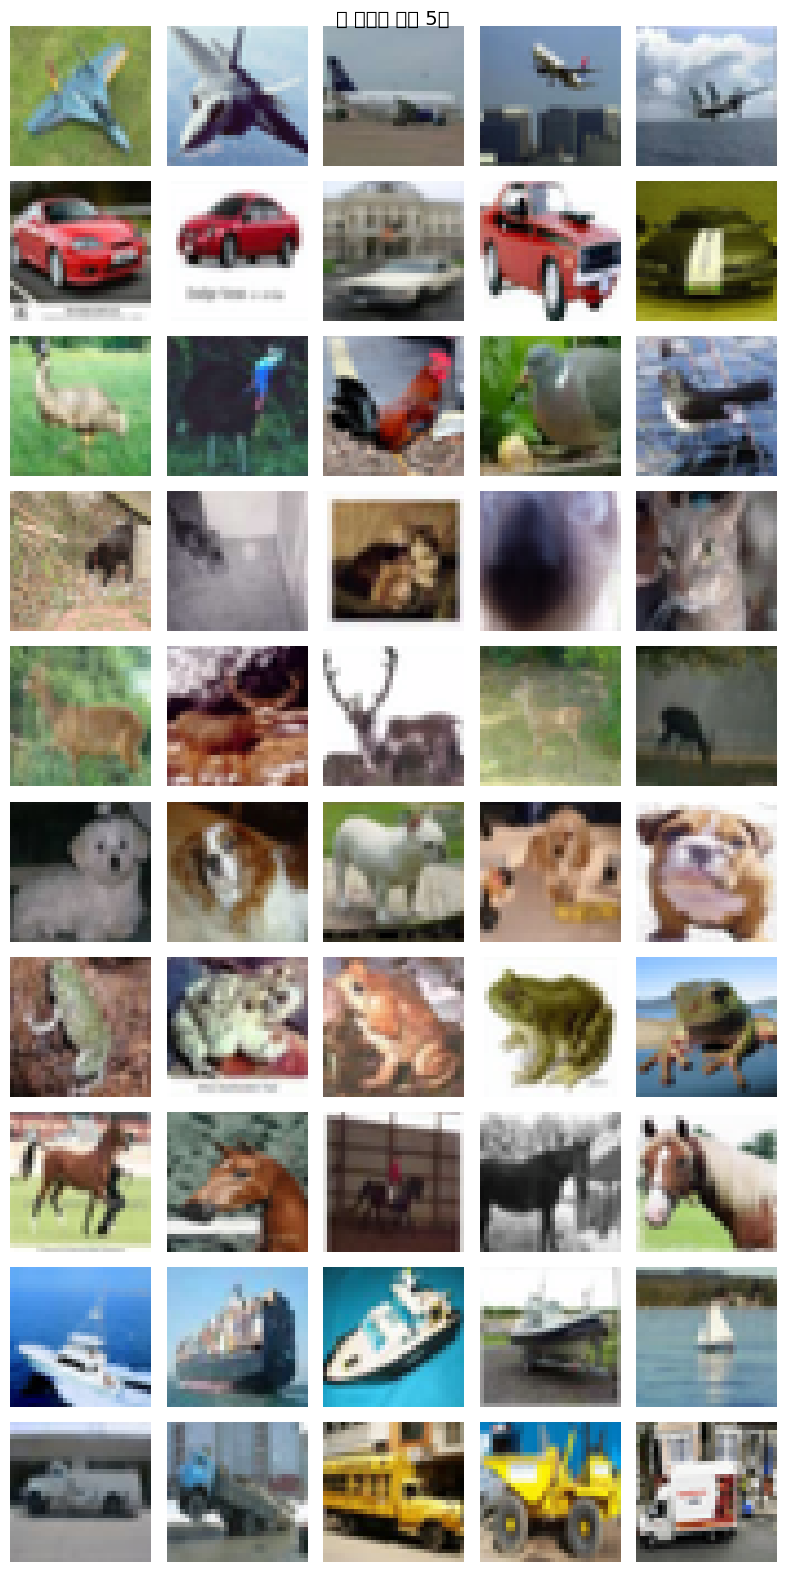

In [3]:
# (1) 클래스별 샘플 5장씩 시각화
import math
fig, axes = plt.subplots(10, 5, figsize=(8,16))
counts = {c:0 for c in class_names}
for x,y in train_loader:
    for img, lab in zip(x, y):
        c = class_names[lab.item()]
        if counts[c] < 5:
            ax = axes[class_names.index(c), counts[c]]
            ax.imshow(denorm(img)); ax.set_axis_off()
            if counts[c]==0: ax.set_ylabel(c, rotation=0, labelpad=30, va='center')
            counts[c]+=1
    if all(counts[c]>=5 for c in class_names): break
plt.suptitle('각 클래스 샘플 5장', fontsize=14); plt.tight_layout(); plt.show()

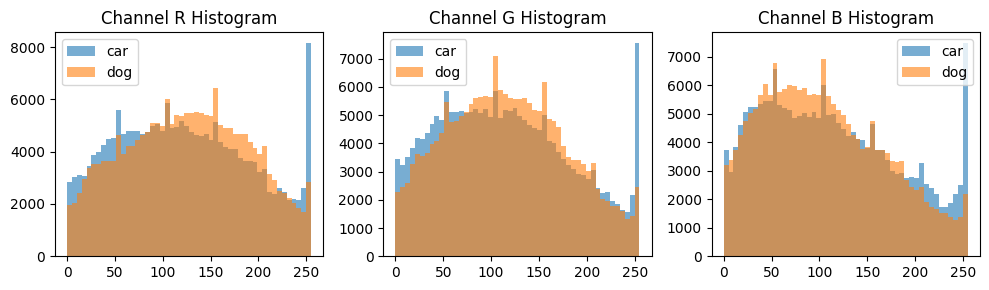

cars array: (200, 32, 32, 3) dogs array: (200, 32, 32, 3)


In [4]:
# (2) 자동차 vs 개 RGB 채널별 히스토그램 비교
from torchvision.datasets import CIFAR10

raw_train = CIFAR10(root='./data', train=True, download=False)  # PIL 이미지 접근용
def collect_pixels(label_name, max_imgs=200):
    idx_label = class_names.index(label_name)
    vals = []
    cnt = 0
    for img, lab in raw_train:
        if lab == idx_label:
            vals.append(np.array(img))  # (H,W,3), 0~255
            cnt += 1
            if cnt>=max_imgs: break
    arr = np.stack(vals, axis=0)  # (N,H,W,3)
    return arr

cars = collect_pixels('automobile', max_imgs=200)
dogs = collect_pixels('dog', max_imgs=200)

plt.figure(figsize=(10,3))
for i, ch in enumerate(['R','G','B']):
    plt.subplot(1,3,i+1)
    plt.hist(cars[:,:,:,i].ravel(), bins=50, alpha=0.6, label='car')
    plt.hist(dogs[:,:,:,i].ravel(), bins=50, alpha=0.6, label='dog')
    plt.title(f'Channel {ch} Histogram'); plt.legend()
plt.tight_layout(); plt.show()

print('cars array:', cars.shape, 'dogs array:', dogs.shape)

## 2. Baseline 비교 (≈6분)

**말하기 포인트:**  
- MLP는 공간 정보를 활용하지 못함 → 파라미터 수 대비 비효율적.  
- CNN은 지역(커널) 단위로 가중치를 공유 → 효율성↑, 일반화↑.

**질문:** “같은 파라미터 수라면 어떤 구조가 더 유리할까요?”


In [5]:
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(32*32*3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.fc(self.flatten(x))

class CNN_V1(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

mlp = MLP().to(device)
cnn = CNN_V1().to(device)
print('MLP params:', count_params(mlp))
print('CNN_V1 params:', count_params(cnn))

MLP params: 789258
CNN_V1 params: 94538


In [6]:
def train_epoch(model, loader, loss_fn, optim_):
    model.train(); tl=0; tc=0; n=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optim_.zero_grad()
        out = model(x); loss = loss_fn(out,y)
        loss.backward(); optim_.step()
        tl += loss.item()*x.size(0)
        tc += (out.argmax(1)==y).sum().item(); n += x.size(0)
    return tl/n, tc/n

@torch.no_grad()
def eval_epoch(model, loader, loss_fn):
    model.eval(); tl=0; tc=0; n=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x); loss = loss_fn(out,y)
        tl += loss.item()*x.size(0)
        tc += (out.argmax(1)==y).sum().item(); n += x.size(0)
    return tl/n, tc/n

In [7]:
criterion = nn.CrossEntropyLoss()
def train_model(model, epochs=5, lr=1e-3):
    optim_ = optim.Adam(model.parameters(), lr=lr)
    hist = {'train_acc':[], 'val_acc':[], 'train_loss':[], 'val_loss':[]}
    for ep in range(1, epochs+1):
        tr_l, tr_a = train_epoch(model, train_loader, criterion, optim_)
        va_l, va_a = eval_epoch(model, val_loader, criterion)
        hist['train_loss'].append(tr_l); hist['val_loss'].append(va_l)
        hist['train_acc'].append(tr_a);  hist['val_acc'].append(va_a)
        print(f'[Ep {ep}/{epochs}] train={tr_a:.3f}/{tr_l:.3f}  val={va_a:.3f}/{va_l:.3f}')
    return hist

mlp_hist = train_model(mlp, epochs=5)
cnn_hist = train_model(cnn, epochs=10)  # CNN은 조금 더 학습

[Ep 1/5] train=0.380/1.805  val=0.455/1.559
[Ep 2/5] train=0.443/1.594  val=0.482/1.493
[Ep 3/5] train=0.464/1.539  val=0.485/1.479
[Ep 4/5] train=0.475/1.500  val=0.477/1.487
[Ep 5/5] train=0.494/1.463  val=0.496/1.462
[Ep 1/10] train=0.298/1.861  val=0.394/1.637
[Ep 2/10] train=0.422/1.571  val=0.487/1.436
[Ep 3/10] train=0.478/1.439  val=0.525/1.352
[Ep 4/10] train=0.508/1.361  val=0.537/1.296
[Ep 5/10] train=0.531/1.301  val=0.579/1.205
[Ep 6/10] train=0.554/1.253  val=0.587/1.169
[Ep 7/10] train=0.569/1.212  val=0.609/1.125
[Ep 8/10] train=0.585/1.166  val=0.610/1.102
[Ep 9/10] train=0.599/1.133  val=0.630/1.056
[Ep 10/10] train=0.609/1.107  val=0.641/1.022


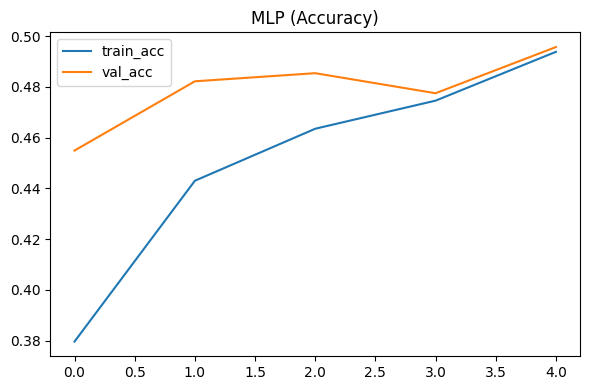

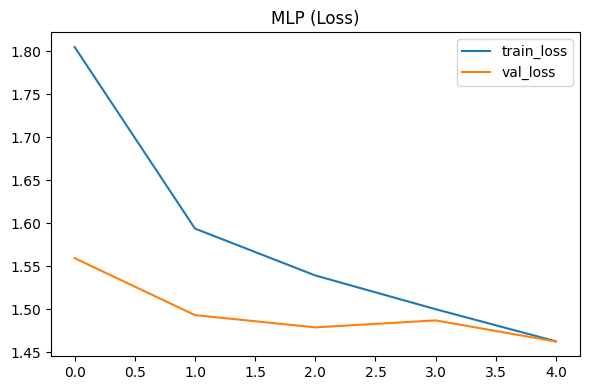

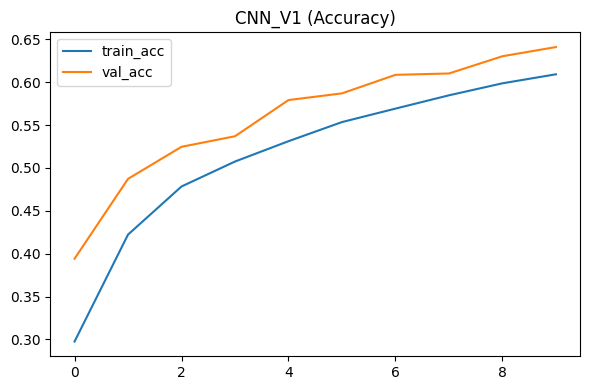

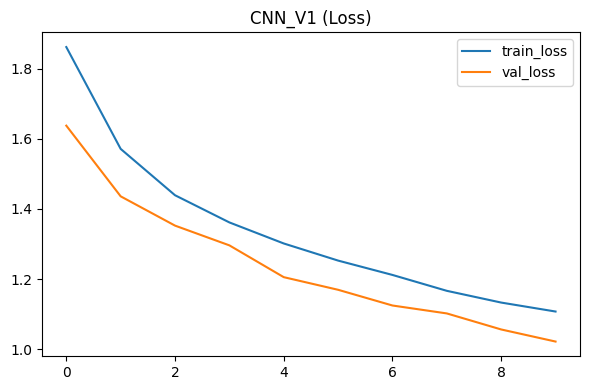

In [8]:
# 학습곡선 나란히 플롯
def plot_hist(h, title):
    plt.figure(figsize=(6,4))
    plt.plot(h['train_acc'], label='train_acc')
    plt.plot(h['val_acc'], label='val_acc')
    plt.title(title+'(Accuracy)'); plt.legend(); plt.tight_layout(); plt.show()
    plt.figure(figsize=(6,4))
    plt.plot(h['train_loss'], label='train_loss')
    plt.plot(h['val_loss'], label='val_loss')
    plt.title(title+'(Loss)'); plt.legend(); plt.tight_layout(); plt.show()

plot_hist(mlp_hist, 'MLP ')
plot_hist(cnn_hist, 'CNN_V1 ')

## 3. CNN 내부 시각화 (≈5분)

**말하기 포인트:**  
- 초기 필터는 엣지/색상 같은 저수준 특징을 뽑습니다.  
- 이후 레이어로 갈수록 패턴/형태 같은 고수준 특징으로 이어집니다.


/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/1156136407.py:16: UserWarning: Glyph 52395 (\N{HANGUL SYLLABLE CEOS}) missing from font(s) DejaVu Sans.
  plt.suptitle('첫 Conv 필터(평균 채널)'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/1156136407.py:16: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from font(s) DejaVu Sans.
  plt.suptitle('첫 Conv 필터(평균 채널)'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/1156136407.py:16: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.suptitle('첫 Conv 필터(평균 채널)'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/1156136407.py:16: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.suptitle('첫 Conv 필터(평균 채널)'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4

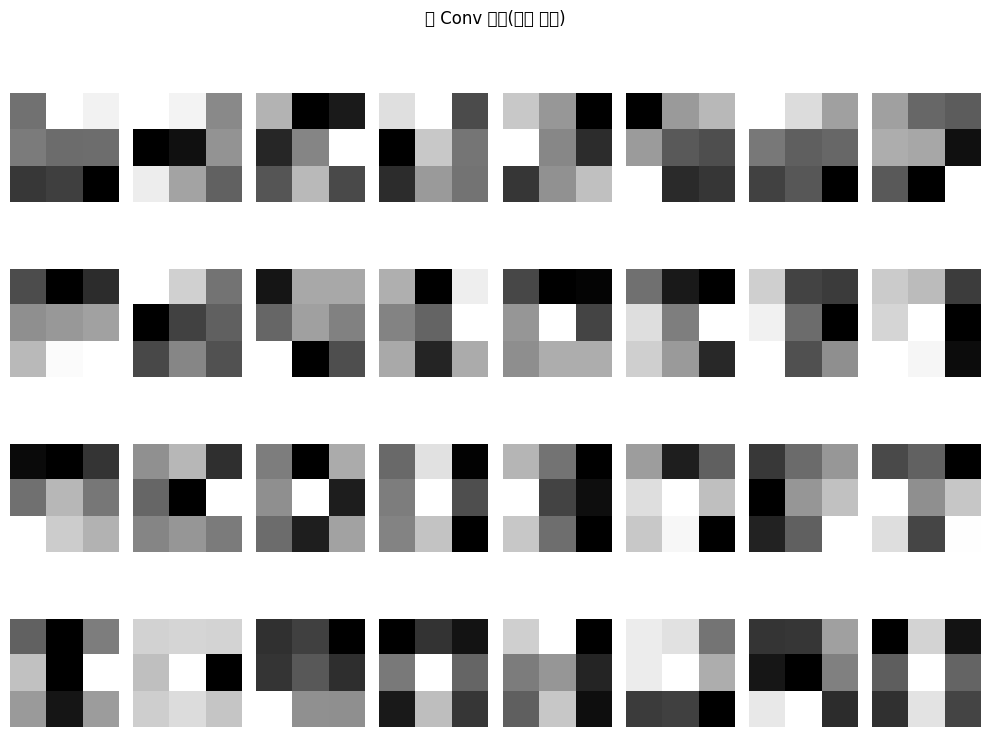

In [9]:
# (1) 첫 Conv 레이어 필터 가중치 시각화
w = cnn.features[0].weight.data.cpu()  # (out, in, k, k)
w_min, w_max = w.min().item(), w.max().item()
grid = []
for i in range(min(32, w.shape[0])):  # 32개까지만
    filt = w[i]
    # 채널 평균으로 2D 맵 만들기
    fmap = filt.mean(0)
    grid.append((fmap - w_min)/(w_max - w_min + 1e-9))
grid = torch.stack(grid,0).numpy()

cols = 8; rows = (len(grid)+cols-1)//cols
plt.figure(figsize=(10, 2*rows))
for i, g in enumerate(grid):
    plt.subplot(rows, cols, i+1); plt.imshow(g, cmap='gray'); plt.axis('off')
plt.suptitle('첫 Conv 필터(평균 채널)'); plt.tight_layout(); plt.show()

/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/1649260289.py:10: UserWarning: Glyph 52395 (\N{HANGUL SYLLABLE CEOS}) missing from font(s) DejaVu Sans.
  plt.suptitle('첫 Conv Feature Maps'); plt.tight_layout(); plt.show()


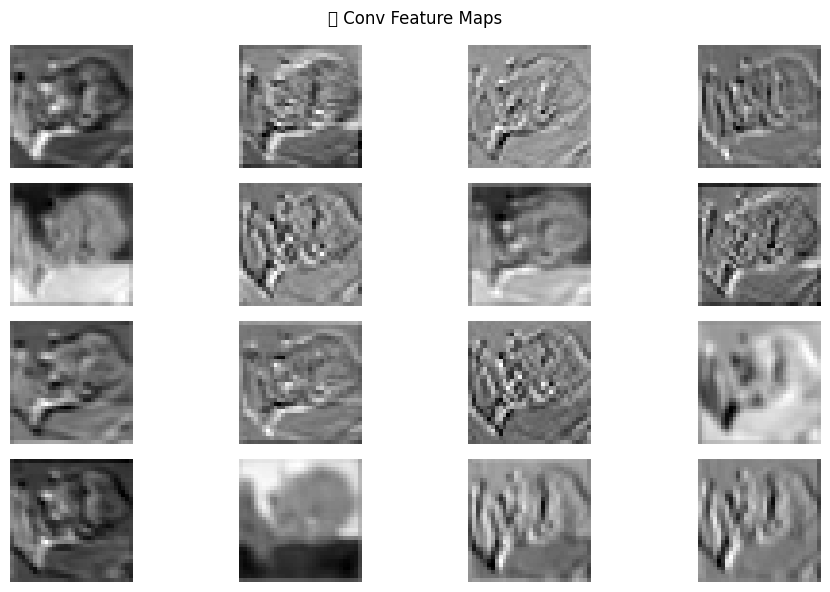

In [10]:
# (2) 테스트 이미지 1장의 첫 Conv 특징맵
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x[0:1].to(device)
    features = cnn.features[0](x)  # 첫 Conv 결과 (N=1, C=32, H, W)
plt.figure(figsize=(10,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(features[0,i].cpu(), cmap='gray'); plt.axis('off')
plt.suptitle('첫 Conv Feature Maps'); plt.tight_layout(); plt.show()

## 4. 오분류 분석 심화 (≈5분)

**말하기 포인트:**  
- Confusion Matrix로 **자주 헷갈리는 클래스 쌍**을 찾습니다.  
- 해당 쌍의 샘플을 여러 장 보여주며, 공통 패턴을 토론합니다.


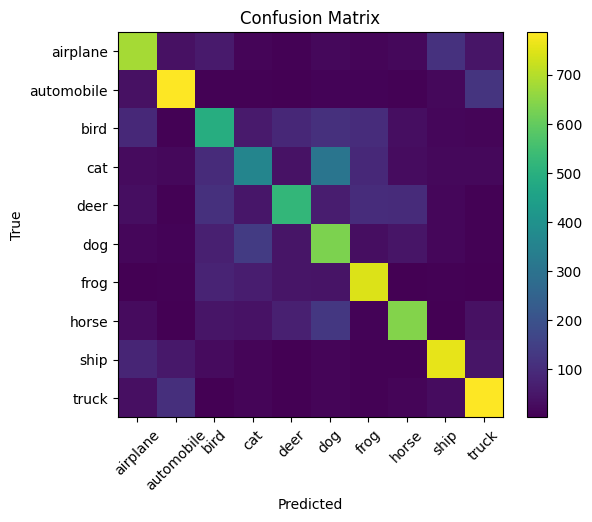

Top-3 혼동 클래스 쌍: [('cat', 'dog', 307), ('dog', 'cat', 137), ('horse', 'dog', 127)]


/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3837015562.py:55: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  plt.suptitle(f'혼동 사례: {class_names[i]} vs {class_names[j]}'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3837015562.py:55: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.suptitle(f'혼동 사례: {class_names[i]} vs {class_names[j]}'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3837015562.py:55: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.suptitle(f'혼동 사례: {class_names[i]} vs {class_names[j]}'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3837015562.py:55: UserWarning: Glyph 47168 (\N{HANGUL SYLLABLE RYE}) missing from font(s) DejaVu Sans.
  plt.suptitle(f'혼동 사례: {class_names[i]} vs {cl

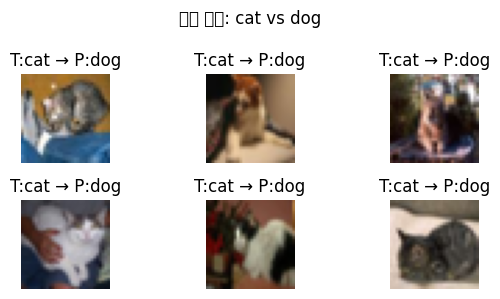

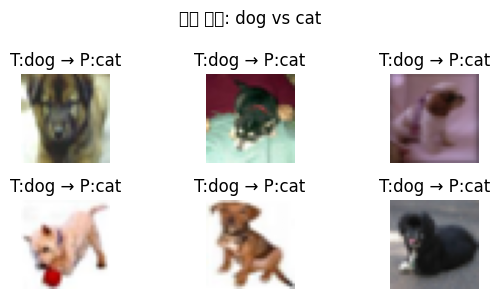

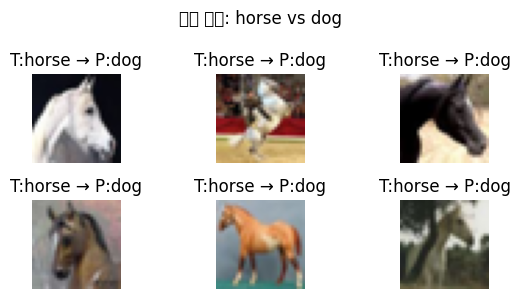

In [11]:
@torch.no_grad()
def get_all_preds(model, loader):
    model.eval(); ys=[]; ps=[]
    for x,y in loader:
        x = x.to(device); out = model(x)
        ps.append(out.argmax(1).cpu().numpy()); ys.append(y.numpy())
    return np.concatenate(ys), np.concatenate(ps)

y_true, y_pred = get_all_preds(cnn, test_loader)

cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix')
plt.colorbar(); plt.xticks(range(10), class_names, rotation=45); plt.yticks(range(10), class_names)
plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

# Top-3 혼동 클래스 쌍 추출
pairs = []
for i in range(10):
    for j in range(10):
        if i!=j and cm[i,j]>0:
            pairs.append(((i,j), cm[i,j]))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:3]
print('Top-3 혼동 클래스 쌍:', [(class_names[i], class_names[j], n) for (i,j), n in pairs])

# 각 쌍에서 오분류 샘플 6장 표시
raw_test = datasets.CIFAR10(root='./data', train=False, download=False, transform=transforms.ToTensor())
idx_map = list(range(len(raw_test)))  # 원본 인덱스 접근용
# test_loader 순서와 raw_test 인덱스는 다를 수 있으므로, 라벨 기반으로 스캔
def find_mismatch_indices(true_label, pred_label, max_show=6):
    out_idx = []
    count = 0
    # brute-force: 전체 예측을 다시 순차로 확인
    ptr = 0
    for batch_x, batch_y in DataLoader(test_set, batch_size=128, shuffle=False):
        with torch.no_grad():
            logits = cnn(batch_x.to(device))
            preds = logits.argmax(1).cpu().numpy()
        for k in range(len(batch_y)):
            if batch_y[k].item()==true_label and preds[k]==pred_label:
                out_idx.append(ptr+k)
                count += 1
                if count>=max_show: return out_idx
        ptr += len(batch_y)
    return out_idx

for (i,j), _ in pairs:
    ids = find_mismatch_indices(i,j, max_show=6)
    if not ids: continue
    plt.figure(figsize=(6,3))
    for k, idx in enumerate(ids):
        img,_ = raw_test[idx]
        plt.subplot(2,3,k+1); plt.imshow(img.permute(1,2,0)); plt.axis('off')
        plt.title(f'T:{class_names[i]} → P:{class_names[j]}')
    plt.suptitle(f'혼동 사례: {class_names[i]} vs {class_names[j]}'); plt.tight_layout(); plt.show()

## 5. 성능 개선 기법 (≈6분)

**말하기 포인트:**  
- 증강, 정규화, 드롭아웃/배치정규화, 옵티마이저 변경 등으로 과적합을 제어하고 일반화를 개선합니다.


[CNN_V2][SGD][Ep 1] train=0.313/1.802  val=0.355/1.777
[CNN_V2][SGD][Ep 2] train=0.454/1.468  val=0.519/1.322
[CNN_V2][SGD][Ep 3] train=0.520/1.312  val=0.516/1.318
[CNN_V2][SGD][Ep 4] train=0.558/1.220  val=0.483/1.488
[CNN_V2][SGD][Ep 5] train=0.585/1.150  val=0.555/1.215
[CNN_V2][SGD][Ep 6] train=0.605/1.100  val=0.613/1.086
[CNN_V2][SGD][Ep 7] train=0.622/1.052  val=0.603/1.088
[CNN_V2][SGD][Ep 8] train=0.631/1.020  val=0.648/0.981
[CNN_V2][SGD][Ep 9] train=0.650/0.984  val=0.651/0.974
[CNN_V2][SGD][Ep 10] train=0.655/0.966  val=0.658/0.979
[CNN_V2][SGD][Ep 11] train=0.667/0.933  val=0.685/0.873


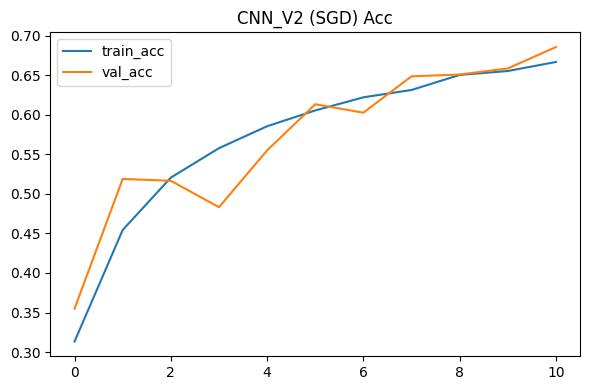

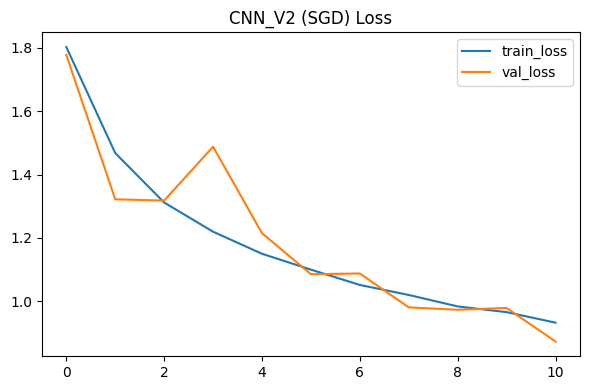

In [12]:
# 증강 파이프라인과 BN/Dropout을 포함한 개선 모델
aug_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616))
])
train_full_aug = datasets.CIFAR10(root='./data', train=True, download=False, transform=aug_tf)
train_set2, val_set2 = random_split(train_full_aug, [train_len, val_len])
train_loader2=DataLoader(train_set2,batch_size=128,shuffle=True,num_workers=0)
val_loader2  =DataLoader(val_set2,  batch_size=128,shuffle=False,num_workers=0)

class CNN_V2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.3),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )
    def forward(self,x): return self.net(x)

cnn2 = CNN_V2().to(device)
criterion = nn.CrossEntropyLoss()

# Optimizer 실험: SGD vs Adam
opt_name = 'SGD'  # 'Adam'으로 변경하여 비교 실험
optimizer = optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9) if opt_name=='SGD' else optim.Adam(cnn2.parameters(), lr=1e-3)

hist2={'train_acc':[],'val_acc':[],'train_loss':[],'val_loss':[]}
for ep in range(1, 12):  # 약간 더 학습
    tr_l,tr_a = train_epoch(cnn2, train_loader2, criterion, optimizer)
    va_l,va_a = eval_epoch(cnn2, val_loader2, criterion)
    hist2['train_loss'].append(tr_l); hist2['val_loss'].append(va_l)
    hist2['train_acc'].append(tr_a);  hist2['val_acc'].append(va_a)
    print(f'[CNN_V2][{opt_name}][Ep {ep}] train={tr_a:.3f}/{tr_l:.3f}  val={va_a:.3f}/{va_l:.3f}')

# 성능 비교
def plot_hist(h, title):
    plt.figure(figsize=(6,4)); plt.plot(h['train_acc'],label='train_acc'); plt.plot(h['val_acc'],label='val_acc'); plt.title(title+' Acc'); plt.legend(); plt.tight_layout(); plt.show()
    plt.figure(figsize=(6,4)); plt.plot(h['train_loss'],label='train_loss'); plt.plot(h['val_loss'],label='val_loss'); plt.title(title+' Loss'); plt.legend(); plt.tight_layout(); plt.show()

plot_hist(hist2, f'CNN_V2 ({opt_name})')

## 6. 실습 챌린지 (≈2분)

- **레이어 수 늘리기**: Conv 블록 추가 후 성능/시간 변화 비교  
- **증강 강도 조절**: `ColorJitter`, `RandomErasing` 등 추가하여 일반화 확인  
- **Optimizer 교체**: SGD ↔ Adam, 학습률 스케줄러(`StepLR`, `CosineAnnealingLR`) 도입
